In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time

torch.set_default_dtype(torch.float64)
torch.manual_seed(0)
device = 'cuda:0'

In [ ]:
def l1_norm(x):
  # assumes shape of x is (n_samples x dim)
  return torch.norm(x, dim=1, p=1)

def l1_norm_noisy(x):
  # assumes shape of x is (n_samples x dim)
  return (1 + 5e-3*torch.randn(x.shape[0], device=x.device))*torch.norm(x, dim=1, p=1)

def l1_norm_prox(x, t=0.5):
  shrink = nn.Softshrink(lambd=t)
  return shrink(x)

In [ ]:
# approximate prox
torch.manual_seed(9)
def compute_prox(x, t, f, delta=1e-1, int_samples=100, alpha=1.0, linesearch_iters=0, device='cpu'):
      ''' 
          compute prox.
          input is a single vector x of size (dim x 1)
      '''
      assert(x.shape[1]==1)
      assert(x.shape[0]>=1)
      linesearch_iters +=1
      standard_dev = np.sqrt(delta*t/alpha)

      dim = x.shape[0]

      y = standard_dev * torch.randn(int_samples, dim, device=device) + x.permute(1,0) # here y has shape (n_samples x dim)

      # one of the main difficulties is division by small delta drives exp term to 0
      # f assumes y has shape n_samples x dim
      exp_term = torch.exp(-f(y)*(alpha/delta))

      assert(exp_term.shape[0]==int_samples)

      # if exponential zeros out, perform linesearch
      bool_check = (exp_term > 1e-6)
      if bool_check.prod()==0.0:
        alpha = 0.5*alpha
        return compute_prox(x, t, f, delta=delta, int_samples=int_samples, alpha=alpha, linesearch_iters=linesearch_iters, device=device)
      else:
        v_delta       = torch.mean(exp_term)
        numerator = y*exp_term.view(int_samples, 1)
        numerator = torch.mean(numerator, dim=0)

        
        prox_term = numerator/v_delta
        prox_term = prox_term.view(-1, 1) 

        assert(prox_term.shape == x.shape)

        # important, must add two tensors of shape (n_samples x 1).
        # if one tensor is n_samples x 1 and the other is n_samples. The resulting addition is n_samples x n_samples! 
        bool_check2 = prox_term < np.inf 
        assert(bool_check2.prod())

        envelope = -delta * torch.log(v_delta)

        return prox_term, linesearch_iters, envelope

### LADMM Algorithm to obtain true solution of
\begin{equation} 
        \min_{x\in\mathbb{R}^{1000}} \; \|Wx\|_1
        \quad \text{such that} \quad Ax=b
\end{equation}

given by

\begin{align}
    p^{k+1} & = \eta_\lambda \left(p^k + \lambda(\nu_1^k + \alpha(Wx^k - p^k)) \right)
    \\
    \nu_1^{k+1} &= \nu_1^k + \alpha(Wx^k - p^{k+1})
    \\
    \nu_2^{k+1} &= \nu_2^k + \alpha(Ax^k -b) 
    \\
    r^{k} & =  W^\top \left( 2\nu_1^{k+1} - \nu_1^k  \right) + A^\top \left( 2\nu_2^{k+1} - \nu_2^k \right)\\
    x^{k+1} & = x^k - \beta r^k,
\end{align}  

where $\alpha$, $\beta$, and $\lambda$ are chosen parameters

In [ ]:
torch.manual_seed(1)
dim = int(1e3)
A = torch.randn(int(dim/2), dim, device=device)
W = 1e-1*torch.randn(dim, dim, device=device)
# W = torch.eye(dim, device=device)
# x_true = torch.randn(dim,1, device=device)
# b = A.matmul(x_true)
b = torch.randn(int(dim/2), 1, device=device)

alpha = 1e-3
beta = 1e-1
lambd = 1e-2 

def ladmm(x0, W, A, b, max_iters, tol=1e-6, alpha=1e-2, beta=1e-1, lambd=1e-2, verbose=True):

  assert len(x0.shape)==2 and x0.shape[1]==1
  dim1 = A.shape[1]
  dim2 = A.shape[0]
  # note if A is underdetermined, dim1 < dim2 

  device = x0.device
  xk = x0
  pk = torch.zeros(dim1, 1, device=device)
  nu1k = torch.zeros(dim1, 1, device=device)
  nu2k = torch.zeros(dim2, 1, device=device)

  fk_hist = torch.zeros(max_iters)
  fixed_point_residual_hist = torch.zeros(max_iters)

  for i in range(max_iters):
    Wxk = W.matmul(xk)
    temp = pk + lambd*(nu1k + alpha*(Wxk - pk))
    pk = l1_norm_prox(temp, t=lambd) 
    nu1k_plus1 = nu1k + alpha*(Wxk - pk)
    nu2k_plus1 = nu2k + alpha*(A.matmul(xk) - b)
    rk = W.t().matmul(2*nu1k_plus1 - nu1k) + A.t().matmul(2*nu2k_plus1 - nu2k)
    xk = xk - beta*rk

    fk = l1_norm(W.matmul(xk).permute(1,0)).cpu()
    fk_hist[i] = fk
    fixed_point_residual = torch.norm(beta*rk).cpu()
    fixed_point_residual_hist[i] = fixed_point_residual

    if verbose:
      print('iter: ', i, ', fk: ', fk, ', fixed pt res: ', fixed_point_residual)

    if fixed_point_residual <= tol:
      x_sol = xk
      fk_hist = fk_hist[0:i]
      fixed_point_residual_hist = fixed_point_residual_hist[0:i]
      print('LADMM converged to fixed pt. res. of', fixed_point_residual, ', after ', i, ' iterations ')
      break

  return xk, fk_hist, fixed_point_residual_hist

def hj_mm(x0, W, A, b, max_iters, delta=1e-1, int_samples=int(1e2), step_size=1e-1, tol=1e-8, lambd=0.5, verbose=True, x_true=[], print_freq=1):

  assert len(x0.shape)==2 and x0.shape[1]==1
  dim1 = A.shape[1]
  dim2 = A.shape[0]

  assert b.shape[1]==1 and b.shape[0]==dim2
  # note if A is underdetermined, dim1 < dim2 

  device = x0.device
  xk = x0
  uk = torch.zeros(dim2, 1, device=device)

  fk_hist = torch.zeros(max_iters)
  fixed_point_residual_hist = torch.zeros(max_iters)
  rel_err_hist = torch.zeros(max_iters)
  linesearch_iters_hist = torch.zeros(max_iters)

  # current_scalar = 1.0

  def f_noisy(x):
    return l1_norm_noisy(W.matmul(x.permute(1,0)).permute(1,0))

  res = A.matmul(xk)-b

  assert res.shape[0]==dim2 and res.shape[1]==1


  for i in range(max_iters):

    start_time = time.time()

    xold = xk.clone()

    res = A.matmul(xk)-b
    xk = xk - step_size*A.t().matmul(uk + lambd*res)
    xk, linesearch_iters, temp_envelope = compute_prox(xk, step_size, f_noisy, delta=delta, int_samples=int_samples, alpha=1.0, device=device)

    # # rescale function (and corresponding dual variable) if too many linesearches were performed, i.e., func values too large
    # if linesearch_iters > 10:
    #   # current_scalar = 2**(-linesearch_iters+1)*current_scalar
    #   current_scalar = 0.99*current_scalar
    #   # uk = 0.99*uk

    # def f_noisy(x):
    #   return current_scalar * l1_norm_noisy(W.matmul(x.permute(1,0)).permute(1,0))

    res = A.matmul(xk)-b
    uk = uk + lambd*(res)

    assert res.shape[0]==A.shape[0] and res.shape[1]==1
    assert uk.shape==res.shape

    Wxk = W.matmul(xk)

    fk = l1_norm(Wxk.permute(1,0)).cpu()
    fk_hist[i] = fk
    fixed_point_residual = torch.norm(xk - xold).cpu()
    fixed_point_residual_hist[i] = fixed_point_residual.cpu()
    rel_err = (torch.norm(xk - x_true)/torch.norm(x_true)).cpu()
    rel_err_hist[i] = rel_err.cpu()
    linesearch_iters_hist[i] = linesearch_iters

    end_time = time.time()
    iter_time = end_time - start_time

    if verbose:
      if (i+1)%print_freq==0:
        print('iter: ', i+1, ', fixed pt res: ', fixed_point_residual, ', ls: ', linesearch_iters,  ', rel_err: ', rel_err, ', time: ', iter_time)

  return xk, fk_hist, fixed_point_residual_hist, rel_err_hist, linesearch_iters_hist

def grad_descent(x0, A, b, max_iters, tol=1e-6, step_size=1e-1, verbose=True, x_true=[]):

  xk = x0
  grad_norm_hist = torch.zeros(max_iters)
  rel_err_hist = torch.zeros(max_iters)

  for i in range(max_iters):
    start_time = time.time()
    grad_term = A.t().matmul(A.matmul(xk)-b)
    xk =  xk - step_size * grad_term

    grad_norm_hist[i] = torch.norm(grad_term).cpu()
    rel_err = (torch.norm(xk - x_true)/torch.norm(x_true)).cpu()
    rel_err_hist[i] = rel_err
    
    end_time = time.time()
    iter_time = end_time - start_time

    if verbose:
      print('iter = ', i+1, ', grad_norm = ', grad_norm_hist[i], ', rel_err = ', rel_err)

  return xk, grad_norm_hist, rel_err_hist

In [ ]:
# find x_true by starting ladmm over many iterations for different initial conditions
n_trials_true = 3
x_true_array = torch.randn(n_trials_true, dim, device=device)
for i in range(n_trials_true):
  x0 = torch.randn(dim, 1, device=device)

  start_time_ladmm = time.time()
  x_true, fk_admm_hist, fixed_point_residual_admm_hist = ladmm(x0, W, A, b, int(5e4), alpha=alpha, lambd=lambd, beta=beta, verbose=False, tol=1e-6)
  end_time_ladmm = time.time()
  time_ladmm = end_time_ladmm - start_time_ladmm
  print('trial ', i, ', time = ', time_ladmm)
  x_true_array[i, :] = x_true.view(-1)
  assert(max(x_true)<np.inf)

LADMM converged to fixed pt. res. of tensor(9.9999e-07) , after  33947  iterations 
trial  0 , time =  19.314524173736572
LADMM converged to fixed pt. res. of tensor(1.0000e-06) , after  34690  iterations 
trial  1 , time =  19.854499340057373


KeyboardInterrupt: ignored

In [ ]:
torch.norm(x_true_array.permute(1,0) - x_true, dim=0)

In [ ]:
# get relative errors for ladmm_no_prox.
max_iters = int(1e4)
U, s, Vt = torch.svd(A.t().matmul(A))
step_size = 1/s.max().cpu() - 1e-8
lambd=0.5

In [ ]:
xopt_GD, grad_norm_hist_GD, rel_err_hist_GD = grad_descent(x0, A, b, max_iters, step_size=step_size, verbose=False, x_true=x_true)

### Vary $\delta$

In [ ]:
# Average runs over 30 trials: standalone
n_trials = 1
# delta_array = [1e-2, 1e-1, 1.0, 10, 100]
delta_array = [1e-1]

xopt_HJ_lmm_delta_array = torch.zeros(len(delta_array), x_true.shape[0], x_true.shape[1])
fk_HJ_lmm_hist_delta_array = torch.zeros(len(delta_array), max_iters)
norm_diff_HJ_lmm_hist_delta_array = torch.zeros(len(delta_array), max_iters)
rel_err_lmm_hist_delta_array = torch.zeros(len(delta_array), max_iters)
ls_iters_lmm_hist_delta_array = torch.zeros(len(delta_array), max_iters)

samples_for_varying_delta = int(1e4)

for delta_index in range(len(delta_array)):
  print('delta =', delta_array[delta_index])
  for i in range(n_trials):
    start_time_hj_lmm = time.time()
    current_delta = delta_array[delta_index]
    xopt_HJ_lmm_temp, fk_HJ_lmm_hist_temp, norm_diff_HJ_lmm_hist_temp, rel_err_hist_temp, ls_iters_hist_temp = hj_mm(x0, W, A, b, max_iters, 
                                                                                                  int_samples=samples_for_varying_delta, 
                                                                                                  delta=current_delta,
                                                                                                  lambd = lambd, 
                                                                                                  step_size=step_size,
                                                                                                  verbose=True, 
                                                                                                  print_freq=50,
                                                                                                  x_true=x_true)
    end_time_hj_lmm = time.time()
    time_hj_lmm = end_time_hj_lmm - start_time_hj_lmm
    print('trial ', i+1, ' finished after', time_hj_lmm)
      
    if i==0:
      xopt_HJ_lmm = xopt_HJ_lmm_temp
      fk_HJ_lmm_hist = fk_HJ_lmm_hist_temp
      norm_diff_HJ_lmm_hist = norm_diff_HJ_lmm_hist_temp
      rel_err_hist = rel_err_hist_temp
      ls_iters_hist = ls_iters_hist_temp
    else:
      xopt_HJ_lmm = xopt_HJ_lmm + xopt_HJ_lmm_temp
      fk_HJ_lmm_hist = fk_HJ_lmm_hist + fk_HJ_lmm_hist_temp
      norm_diff_HJ_lmm_hist = norm_diff_HJ_lmm_hist + norm_diff_HJ_lmm_hist_temp
      rel_err_hist = rel_err_hist + rel_err_hist_temp
      ls_iters_hist = ls_iters_hist + ls_iters_hist_temp


  xopt_HJ_lmm_delta_array[delta_index, :, :] = xopt_HJ_lmm/n_trials
  fk_HJ_lmm_hist_delta_array[delta_index, :] = fk_HJ_lmm_hist/n_trials
  norm_diff_HJ_lmm_hist_delta_array[delta_index, :] = norm_diff_HJ_lmm_hist/n_trials
  rel_err_lmm_hist_delta_array[delta_index, :] = rel_err_hist/n_trials 
  ls_iters_lmm_hist_delta_array[delta_index,:] = ls_iters_hist/n_trials
  print('norm(rel_err_hist_temp - rel_err_lmm_hist_delta_array[sample_index,:]) = ', torch.norm(rel_err_hist_temp - rel_err_lmm_hist_delta_array[delta_index,:]))

delta = 0.01
iter:  50 , fixed pt res:  tensor(0.6102) , ls:  15 , rel_err:  tensor(15.2975) , time:  0.03103184700012207
iter:  100 , fixed pt res:  tensor(0.2747) , ls:  15 , rel_err:  tensor(14.2222) , time:  0.03082108497619629
iter:  150 , fixed pt res:  tensor(0.1510) , ls:  15 , rel_err:  tensor(13.3128) , time:  0.03106403350830078
iter:  200 , fixed pt res:  tensor(0.1085) , ls:  15 , rel_err:  tensor(12.4754) , time:  0.03072381019592285
iter:  250 , fixed pt res:  tensor(0.0962) , ls:  15 , rel_err:  tensor(11.7138) , time:  0.03071761131286621
iter:  300 , fixed pt res:  tensor(0.0958) , ls:  15 , rel_err:  tensor(10.9904) , time:  0.030705690383911133
iter:  350 , fixed pt res:  tensor(0.0699) , ls:  14 , rel_err:  tensor(10.2694) , time:  0.028708457946777344
iter:  400 , fixed pt res:  tensor(0.0665) , ls:  14 , rel_err:  tensor(9.5887) , time:  0.028784751892089844
iter:  450 , fixed pt res:  tensor(0.0656) , ls:  14 , rel_err:  tensor(8.9602) , time:  0.028809309005737

Text(0.5, 1.0, 'samples =  10000')

<Figure size 432x288 with 0 Axes>

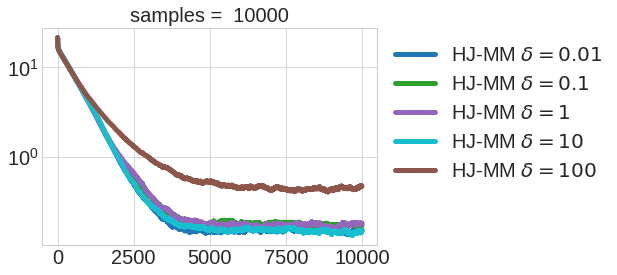

In [ ]:
# plotting parameters
title_fontsize = 22
fontsize       = 20
fig1 = plt.figure()
my_blue = '#1f77b4'
my_orange = '#F97306'

fig1 = plt.figure()
plt.style.use('seaborn-whitegrid')
ax = plt.axes()

ax.semilogy(rel_err_lmm_hist_delta_array[0,:], linewidth=5, color=my_blue)
ax.semilogy(rel_err_lmm_hist_delta_array[1,:], linewidth=5, color='tab:green')
ax.semilogy(rel_err_lmm_hist_delta_array[2,:], linewidth=5, color='tab:purple')
ax.semilogy(rel_err_lmm_hist_delta_array[3,:], linewidth=5, color='tab:cyan')
ax.semilogy(rel_err_lmm_hist_delta_array[4,:], linewidth=5, color='tab:brown')

# ax.set_xlabel("x-axis", fontsize=title_fontsize)
# ax.legend(['HJ-ADMM $\delta=0.001$', 'HJ-ADMM $\delta=0.01$', 'HJ-ADMM $\delta=0.1$', 'HJ-ADMM $\delta=1$', 'HJ-ADMM $\delta=10$'],fontsize=fontsize, bbox_to_anchor=(1.0, 1.0), loc='upper left')
ax.legend(['HJ-MM $\delta=0.01$', 'HJ-MM $\delta=0.1$', 'HJ-MM $\delta=1$', 'HJ-MM $\delta=10$', 'HJ-MM $\delta=100$'],fontsize=fontsize, bbox_to_anchor=(1.0, 1.0), loc='upper left')
ax.tick_params(labelsize=fontsize, which='both', direction='in')
save_str = 'ADMM_noisy_delta_comparison.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

title_str = 'samples =  ' + str(samples_for_varying_delta)
ax.set_title(title_str, fontsize=fontsize)

### Vary Samples

In [ ]:
# torch.manual_seed(3)
# Average runs over 30 trials: standalone
sample_array = [int(1), int(1e2), int(1e3), int(1e4)]

xopt_HJ_lmm_sample_array = torch.zeros(len(sample_array), x_true.shape[0], x_true.shape[1])
fk_HJ_lmm_hist_sample_array = torch.zeros(len(sample_array), max_iters)
norm_diff_HJ_lmm_hist_sample_array = torch.zeros(len(sample_array), max_iters)
rel_err_lmm_hist_sample_array = torch.zeros(len(sample_array), max_iters)
ls_iters_lmm_hist_sample_array = torch.zeros(len(sample_array), max_iters)


delta_for_varying_samples = 10

for sample_index in range(len(sample_array)):
  print('Number of Samples =', sample_array[sample_index])
  for i in range(n_trials):
    start_time_hj_lmm = time.time()
    current_samples = sample_array[sample_index]
    xopt_HJ_lmm_temp, fk_HJ_lmm_hist_temp, norm_diff_HJ_lmm_hist_temp, rel_err_hist_temp, ls_iters_hist_temp = hj_mm(x0, W, A, b, max_iters, 
                                                                                                  int_samples=current_samples, 
                                                                                                  delta=delta_for_varying_samples, 
                                                                                                  step_size=step_size,
                                                                                                  lambd = lambd, 
                                                                                                  verbose=True, 
                                                                                                  print_freq=50,
                                                                                                  x_true=x_true)
    end_time_hj_lmm = time.time()
    time_hj_lmm = end_time_hj_lmm - start_time_hj_lmm
    print('trial ', i+1, ' finished after', time_hj_lmm)

    # print('rel_err_hist_temp = ', rel_err_hist_temp)
      
    if i==0:
      xopt_HJ_lmm = xopt_HJ_lmm_temp
      fk_HJ_lmm_hist = fk_HJ_lmm_hist_temp
      norm_diff_HJ_lmm_hist = norm_diff_HJ_lmm_hist_temp
      rel_err_hist = rel_err_hist_temp
      ls_iters_hist = ls_iters_hist_temp
    else:
      xopt_HJ_lmm = xopt_HJ_lmm + xopt_HJ_lmm_temp
      fk_HJ_lmm_hist = fk_HJ_lmm_hist + fk_HJ_lmm_hist_temp
      norm_diff_HJ_lmm_hist = norm_diff_HJ_lmm_hist + norm_diff_HJ_lmm_hist_temp
      rel_err_hist = rel_err_hist + rel_err_hist_temp
      ls_iters_hist = ls_iters_hist + ls_iters_hist_temp


  xopt_HJ_lmm_sample_array[sample_index, :, :] = xopt_HJ_lmm/n_trials
  fk_HJ_lmm_hist_sample_array[sample_index, :] = fk_HJ_lmm_hist/n_trials
  norm_diff_HJ_lmm_hist_sample_array[sample_index, :] = norm_diff_HJ_lmm_hist/n_trials
  rel_err_lmm_hist_sample_array[sample_index, :] = rel_err_hist/n_trials 
  ls_iters_lmm_hist_sample_array[sample_index,:] = ls_iters_hist/n_trials
  # print('rel_err_hist_array[', sample_index, ', :] = ', rel_err_hist_array[sample_index, :])
  print('norm(rel_err_hist_temp - rel_err_lmm_hist_sample_array[sample_index,:]) = ', torch.norm(rel_err_hist_temp - rel_err_lmm_hist_sample_array[sample_index,:]))

Number of Samples = 1
iter:  50 , fixed pt res:  tensor(17.3257) , ls:  7 , rel_err:  tensor(45.8065) , time:  0.003026723861694336
iter:  100 , fixed pt res:  tensor(17.5355) , ls:  7 , rel_err:  tensor(69.3876) , time:  0.003095865249633789
iter:  150 , fixed pt res:  tensor(23.3226) , ls:  8 , rel_err:  tensor(94.2695) , time:  0.0033142566680908203
iter:  200 , fixed pt res:  tensor(23.3492) , ls:  8 , rel_err:  tensor(119.8460) , time:  0.003891468048095703
iter:  250 , fixed pt res:  tensor(23.4980) , ls:  8 , rel_err:  tensor(140.8206) , time:  0.0033483505249023438
iter:  300 , fixed pt res:  tensor(24.9175) , ls:  8 , rel_err:  tensor(158.1800) , time:  0.003287792205810547
iter:  350 , fixed pt res:  tensor(34.4319) , ls:  9 , rel_err:  tensor(185.6910) , time:  0.00476384162902832
iter:  400 , fixed pt res:  tensor(35.6857) , ls:  9 , rel_err:  tensor(212.5606) , time:  0.0037260055541992188
iter:  450 , fixed pt res:  tensor(34.7535) , ls:  9 , rel_err:  tensor(236.1490) , 

Text(0.5, 1.0, 'delta =  10')

<Figure size 432x288 with 0 Axes>

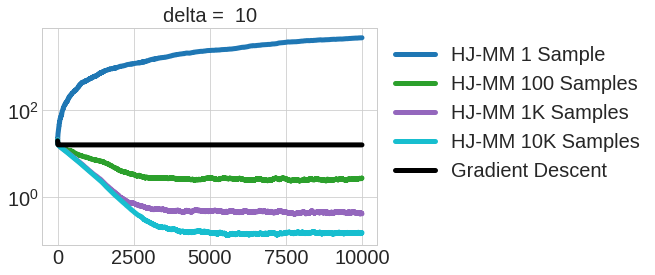

In [ ]:
# plotting parameters
title_fontsize = 22
fontsize       = 20
fig1 = plt.figure()
my_blue = '#1f77b4'
my_orange = '#F97306'

fig1 = plt.figure()
plt.style.use('seaborn-whitegrid')
ax = plt.axes()

ax.semilogy(rel_err_lmm_hist_sample_array[0,:], '-',linewidth=5, color=my_blue)
ax.semilogy(rel_err_lmm_hist_sample_array[1,:], '-', linewidth=5, color='tab:green')
ax.semilogy(rel_err_lmm_hist_sample_array[2,:], linewidth=5, color='tab:purple')
ax.semilogy(rel_err_lmm_hist_sample_array[3,:], linewidth=5, color='tab:cyan')
ax.semilogy(rel_err_hist_GD, linewidth=5, color='k')

# ax.set_xlabel("x-axis", fontsize=title_fontsize)
ax.legend(['HJ-MM 1 Sample', 'HJ-MM 100 Samples', 'HJ-MM 1K Samples', 'HJ-MM 10K Samples', 'Gradient Descent'],fontsize=fontsize, bbox_to_anchor=(1.0, 1.0), loc='upper left')
ax.tick_params(labelsize=fontsize, which='both', direction='in')
save_str = 'ADMM_noisy_sample_comparison.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

title_str = 'delta =  ' + str(delta_for_varying_samples)
ax.set_title(title_str, fontsize=fontsize)